In [ ]:
!apt-get install libsuitesparse-dev && pip install git+https://github.com/tansey-lab/bayestme@6cb143a
!pip install numpy==1.23.5

# Bleeding Correction

This notebook will cover the bleeding correction step of the BayesTME pipeline, using a toy dataset as an example.

BayesTME includes a method `bayestme.synthetic_data.generate_demo_dataset_with_bleeding` that generates a very small and simple toy dataset we can use for testing and demonstration purposes (A real visium 10x dataset would require too much computation to easily run on google colab for free).

This toy dataset has 6 genes, "north_strong"/"north_weak" which are both expressed more towards the top of the slide, "south_strong"/"south_weak"
which are expressed more towards the bottom of the slide, and "noise_strong"/"noise_weak" which are just random noise. The "strong" genes have 10x higher average absolute counts than the "weak" genes.

In [2]:
from bayestme import data, synthetic_data

stdata = synthetic_data.generate_demo_dataset_with_bleeding()

print(stdata.gene_names)

Index(['north_weak', 'north_strong', 'south_weak', 'south_strong',
       'noise_weak', 'noise_strong'],
      dtype='object')


We first visualize the tissue sample by ploting the expression of the "north_strong" gene. We will first plot only the in tissue spots, and then plot all the spots. We will examine the non-tissue spots on the periphery of the slide to determine the direction of bleeding.

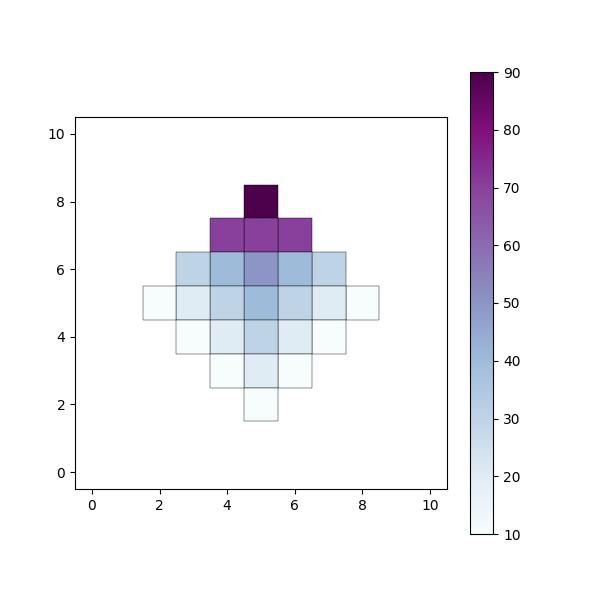

In [28]:
import bayestme.plot.common
from IPython.display import Image
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)
bayestme.plot.common.plot_gene_in_tissue_counts(stdata=stdata, gene='north_strong', output_file='north_strong_in_tissue.jpg')

Image('north_strong_in_tissue.jpg')

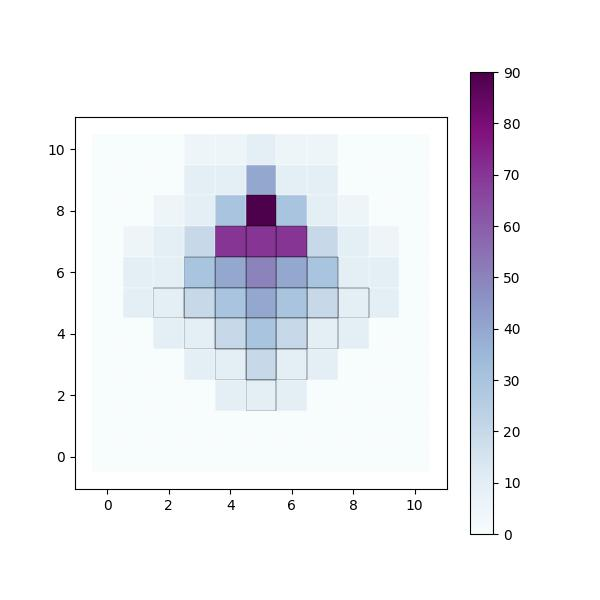

In [3]:
import bayestme.plot.common
from IPython.display import Image
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)
bayestme.plot.common.plot_gene_raw_counts(stdata=stdata, gene='north_strong', output_file='north_strong.jpg')

Image('north_strong.jpg')

Note that the bleeding pattern in this toy dataset is very directional: bleeding of counts is only going in the north direction. We will see our bleed correction method detects and accounts for this uneven directional bleeding.

In the next cell we actually apply bleeding correction.

Bleeding correction has a few parameters you can control.

The parameter "n_top" controls how many genes we look at in order to estimate the bleeding parameters.
Bleeding is not gene specific, so we can use the pattern learned from one set of genes to correct another. Generally we just want to choose genes with good spatial variance in order to estimate the bleeding parameters. We rank the genes by spatial variance and only use the top `n_top` of them for estimating the bleeding parameters

In this example we will use a relatively small `n_top` = 4, this should select our "north" and "south" genes which have higher spatial variance, and filter out the "noise" genes which have lower spatial variance. This means only the north and south genes will be used to calculate the amount of and direction of bleeding. These bleeding "basis functions" will be used to correct all the other genes. Only a small percentage of the total genes are needed for this step.

The bleeding model is fit by alternating minimization.
At each iteration, BayesTME alternates between estimating the basis functions ζˆ and global rates ρˆ0g, and estimating the latent true UMI rates μˆig.

The parameter "max steps" controls how many rounds of alternating minimization to go through. Normally we set this to 5 or more, but for this example we will use a smaller number to make it faster.

The output of the `clean_bleed` will be a tuple of two objects, the first object is the input `bayestme.data.SpatialExpressionDataset` object, but with the read values set to the new corrected values. The second object is the bleeding correction result, and contains the actual bleeding parameters learned.

In [29]:
from bayestme import bleeding_correction

cleaned_dataset, bleed_correction_result = bleeding_correction.clean_bleed(
    dataset=stdata,
    n_top=4,
    max_steps=5
)

Fitting bleed spot rates: 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


BayesTME includes plotting methods for visualizing the results of bleeding correction.

This method will create plots of raw vs corrected read counts, plots of the bleed basis functions, and plots of the bleed vectors.

First lets look at a plot of the bleeding basis functions:

In [30]:
plt.rcParams["figure.figsize"] = (6, 6)
bleeding_correction.plot_basis_functions(
        basis_functions=bleed_correction_result.basis_functions,
        output_dir='.',
        output_format='jpg',
    )

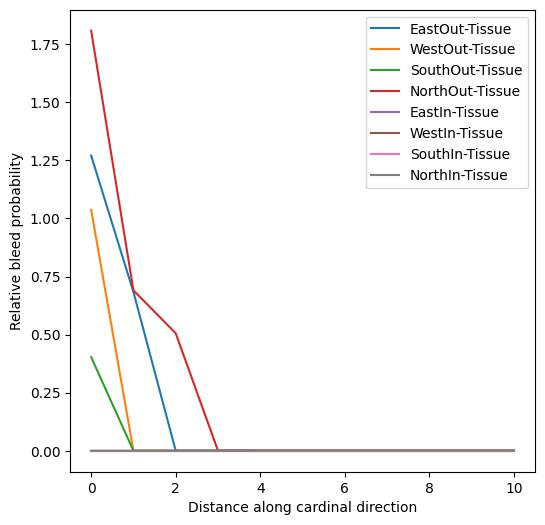

In [31]:
Image('./basis-functions.jpg', unconfined=True)

We see the red line which corresponds to the basis function for reads bleeding out from a tissue spot into non tissue spots, dominates, which makes sense given our data.

Note the in-tissue basis functions are all flat for this toy dataset because we don't observe any bleeding of gene counts found only in the middle of the tissue to the outside. All of our fake genes are expressed in the border regions of the tissue

Next we can look at the bleed vectors:

In [32]:
plt.rcParams["figure.figsize"] = (6, 6)
bleeding_correction.create_top_n_gene_bleeding_plots(
        dataset=stdata,
        corrected_dataset=cleaned_dataset,
        bleed_result=bleed_correction_result,
        output_dir='.',
        output_format='jpg',
        n_genes=6)


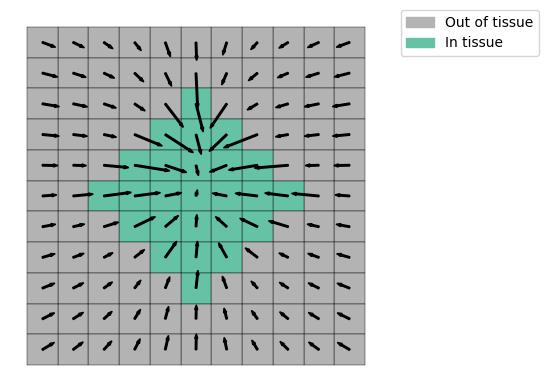

In [33]:
Image('./north_strong_bleed_vectors.jpg')

These vectors show us for each spot, a measure of where the reads in that spot were likely to have bled from. We see the magnitude of the vectors from the north side of the slide are larger, reflecting our belief that bleeding was occuring more in that direction.

Finally we can look at our raw vs corrected counts. We see the absolute gene counts in the northern part of the tissue have increased, reflecting our belief that some of these counts were lost to bleeding in the raw data, but were are now able to "collect" them and assign them to their origin spots.

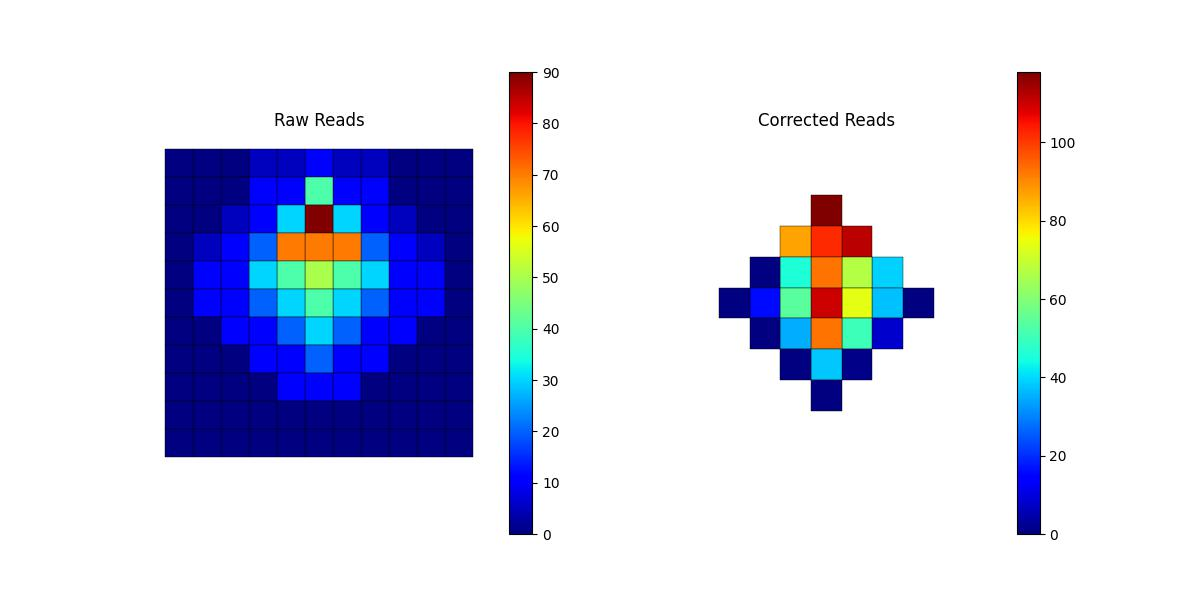

In [34]:
Image('./north_strong_bleeding_plot.jpg', unconfined=True)

A better way to visualize this is to show the difference between the corrected and raw counts as a heat map:

(<Axes: >,
 ArrayView([5, 6, 5, 4, 7, 6, 5, 4, 3, 8, 7, 6, 5, 4, 3, 2, 7, 6, 5, 4, 3,
            6, 5, 4, 5]),
 ArrayView([8, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4,
            3, 3, 3, 2]))

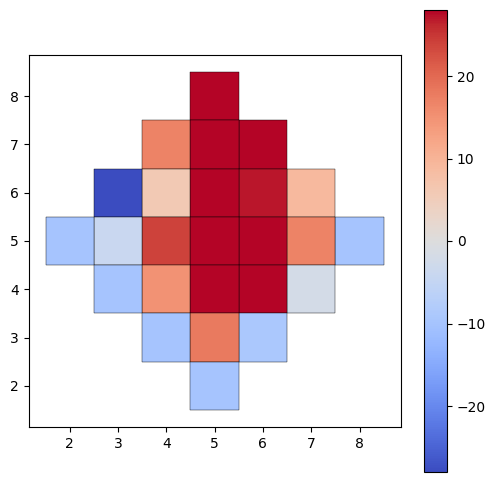

In [35]:
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import CenteredNorm
fig, ax = plt.subplots(1)

gene_idx = np.argmax(stdata.gene_names == "north_strong")

bayestme.plot.common.plot_colored_spatial_polygon(
    fig,
    ax,
    coords=cleaned_dataset.positions_tissue,
    values=(cleaned_dataset.counts[:, gene_idx] - stdata.counts[:, gene_idx]).flatten(),
    layout=cleaned_dataset.layout,
    colormap=cm.coolwarm,
    norm=CenteredNorm()
)

We see the counts were increased more towards the top of the tissue, reflecting our belief in the direction of bleeding.